# Nuberu experimental results

## Reading data

In [9]:
data_file = "https://github.com/asi-uniovi/nuberu-experiments-results/releases/download/v0.1.0/all_requests_data.parquet"

In [10]:
# Read parquet file
import pandas as pd
data = pd.read_parquet(data_file)
data['injected'] = pd.to_datetime(data['injected'], unit='s', origin='2025-06-24 09:00:00')
data['LB'] = data['LB'].replace({
    'smoothWRR': "SWRR",
    "simple": "RR"
})

# Apply a function to every value in the "experiment" column
data['experiment'] = data['experiment'].apply(lambda x: 
                                              x.replace("smoothWRR", "SWRR")
                                              .replace("simple", "RR")
)

## Summary of results



In [11]:
# Compute the percentage of finished requests for each app
filtered_data = data[data['LB'] != 'WRand']
percentage_pivot = filtered_data.pivot_table(
    index=['queue_size', 'termination', 'LB', 'distribution'],
    columns='app', values='finished', aggfunc=lambda x: x.sum() / len(x) * 100,
    fill_value=0).round(1)

# Append the cost of each experiment
cost_summary = data.groupby(['queue_size', 'termination', 'LB', 'distribution'])['cost'].first()
summary_with_cost = percentage_pivot.join(cost_summary)

summary_with_cost

app0   app1   cost
queue_size termination LB   distribution                     
0          drain       RR   poisson        82.6   95.0  10.66
                            trace         100.0   98.5  10.63
                       SWRR poisson        82.6   94.8  10.66
                            trace         100.0   94.4  10.63
           hard        RR   poisson        82.6   94.9  10.62
                            trace         100.0   98.5  10.62
                       SWRR poisson        82.6   94.8  10.62
                            trace         100.0   94.3  10.62
1000       drain       RR   poisson       100.0   99.8  16.56
                            trace         100.0   99.8  16.53
                       SWRR poisson       100.0  100.0  10.66
                            trace         100.0  100.0  10.63
           hard        RR   poisson       100.0   99.2  10.62
                            trace         100.0   99.2  10.62
                       SWRR poisson       100.0  100.0  10.62
                            trace         100.0  100.0  10.62

## Plots

In [12]:
import plotting_utils as pu
import matplotlib.pyplot as plt

## Injected workload plots

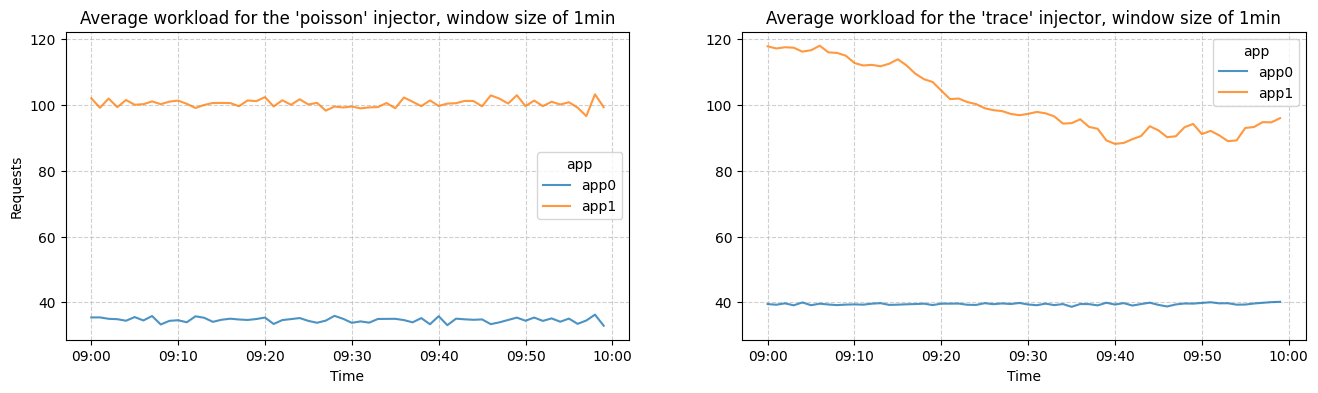

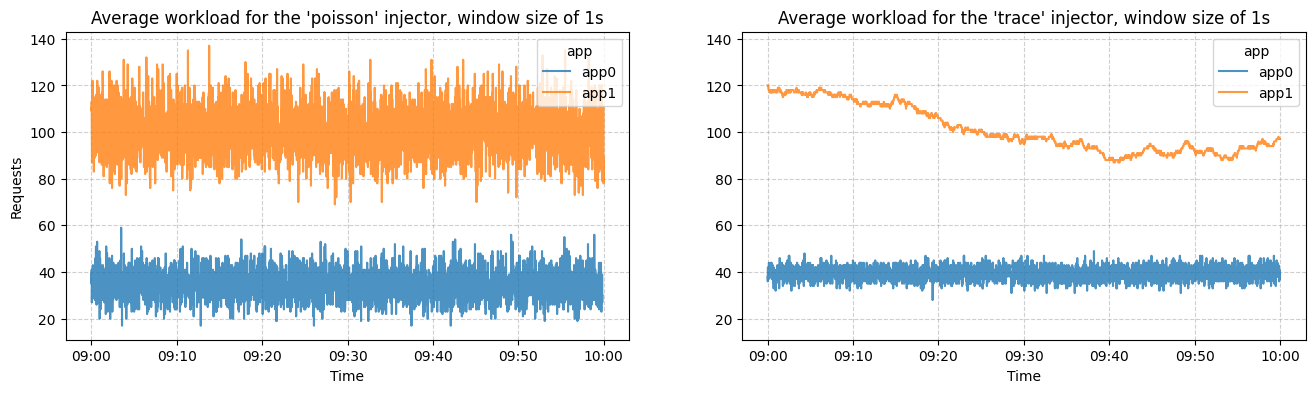

In [13]:
# Generate plots for injected requests in the two cases of injectors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
pu.plot_workloads(data, "poisson", "1min", ax=ax1)
pu.plot_workloads(data, "trace", "1min", ax=ax2)
ax2.tick_params(axis='y', labelleft=True) 

# Generate also plots for 1s window
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
pu.plot_workloads(data, "poisson", "1s", ax=ax1)
pu.plot_workloads(data, "trace", "1s", ax=ax2)
ax2.tick_params(axis='y', labelleft=True) 

# Interactive selection of plots

Note. This section of the notebook is not visible via GitHub, which does not render the `ipywidgets` components.

To view this secition, you need to run the notebook locally.

You can look at the companion notebook `Static-Notebook.ipynb` which contains some pre-rendered example plots.


In [14]:
# Setup for interactive widgets
from ipywidgets import interact, Dropdown, HBox, VBox, Output, Button, HTML
from IPython.display import display, clear_output, Markdown

distribution_options = ["trace", "poisson"]
termination_options = ["hard", "drain"]
lb_options = ["RR", "SWRR"]
queue_size_options = ["q1000", "q0"]
app_options = ["app0", "app1", "all"]
plot_options = ["per app", "per container"]

distribution_selector_j = Dropdown(options=distribution_options, value="trace", description="Distribution")
termination_selector_j = Dropdown(options=termination_options, value="drain", description="Termination")
lb_selector_j = Dropdown(options=lb_options, value="SWRR", description="LB")
queue_selector_j = Dropdown(options=queue_size_options, value="q1000", description="Q")
app_selector_j = Dropdown(options=app_options, value="all", description="App")
plot_selector_j = Dropdown(options=plot_options, value="per app", description="Plot kind")

rt_button = Button(
    description='Plot',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to show the response time for the selected options',
    icon='line-chart'
)

bars_button = Button(
    description='Plot',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to show the completed/lost requests for the selected options',
    icon='bar-chart'
)

controls1 = VBox([
    HTML(value="<h3>Experiment Parameters</h3>"),
    HBox([distribution_selector_j, termination_selector_j]),
    HBox([lb_selector_j, queue_selector_j]),
    HTML(value="<h3>Analysis Options</h3>"),
    HBox([app_selector_j, plot_selector_j]),
    rt_button
])

controls2 = VBox([
    HTML(value="<h3>Experiment Parameters</h3>"),
    HBox([distribution_selector_j, termination_selector_j]),
    HBox([lb_selector_j, queue_selector_j]),
    HTML(value="<h3>Analysis Options</h3>"),
    HBox([app_selector_j, plot_selector_j]),
    bars_button
])

output_area1 = Output()
output_area2 = Output()

def on_rt_button_clicked(b):
    with output_area1:
        clear_output(wait=True)
        grouper = "app" if plot_selector_j.value == "per app" else "ic-cc"
        app = app_selector_j.value if app_selector_j.value != "all" else None
        
        fig, ax = plt.subplots(figsize=(12, 6))
        pu.plot_response_time(
            data,
            distribution=distribution_selector_j.value,
            termination=termination_selector_j.value,
            lb=lb_selector_j.value,
            queue_size=queue_selector_j.value,
            app=app,
            grouper=grouper,
            ax=ax
        )
        display(fig)
        plt.close(fig)

def on_bars_button_clicked(b):
    with output_area2:
        clear_output(wait=True)
        grouper = "app" if plot_selector_j.value == "per app" else "ic-cc"
        app = app_selector_j.value if app_selector_j.value != "all" else None

        fig, ax = plt.subplots(figsize=(15, 7))
        pu.plot_requests_success(
            data,
            distribution=distribution_selector_j.value,
            termination=termination_selector_j.value,
            lb=lb_selector_j.value,
            queue_size=queue_selector_j.value,
            app=app,
            grouper=grouper,
            ax=ax
        )
        display(fig)
        plt.close(fig)

rt_button.on_click(on_rt_button_clicked)
bars_button.on_click(on_bars_button_clicked)

## Response time plots

In [15]:
display(controls1, output_area1)

Output()

## Completed/lost requests bar plot

In [16]:
display(controls2, output_area2)

Output()

# Latex summary table

In [17]:
df_for_latex = summary_with_cost.copy()

# Add "%" and "$" symbols to the appropriate columns
df_for_latex['app0'] = df_for_latex['app0'].astype(str) + r'\%'
df_for_latex['app1'] = df_for_latex['app1'].astype(str) + r'\%'
df_for_latex['cost'] = r"\$" + df_for_latex['cost'].astype(str)

# Rename the index levels for compactness
df_for_latex.index = df_for_latex.index.set_names(['Q', 'Term', 'LB', 'Load'])

# Replace "simple" with "RR" and "weighted" with "WR" in "Load" index
df_for_latex.index = df_for_latex.index.set_levels(
    df_for_latex.index.levels[2].str.replace('simple', 'RR').str.replace('weighted', 'WR'),
    level=2
)

# Process the latex code to tidy up the output
import re
latex_lines = df_for_latex.to_latex(float_format="%.2f").split("\n")
result_lines = []
for _line in latex_lines:
    # Quedarse solo con el primer \cline de la línea y descartar el resto
    if m:=re.match(r"\\cline\{(.*?)\}", _line):
        cell_range = m.group(1)
        result_lines.append(f"\\cline{{{cell_range}}}")
        result_lines.append(r"\addlinespace")
    elif "bottomrule" in _line:
        continue
    else:
        # Mantener las demás líneas tal cual
        result_lines.append(_line)
print("\n".join(result_lines))


\begin{tabular}{lllllll}
\toprule
 &  &  &  & app0 & app1 & cost \\
Q & Term & LB & Load &  &  &  \\
\midrule
\multirow[t]{8}{*}{0} & \multirow[t]{4}{*}{drain} & \multirow[t]{2}{*}{RR} & poisson & 82.6\% & 95.0\% & \$10.66 \\
 &  &  & trace & 100.0\% & 98.5\% & \$10.63 \\
\cline{3-7}
\addlinespace
 &  & \multirow[t]{2}{*}{SWRR} & poisson & 82.6\% & 94.8\% & \$10.66 \\
 &  &  & trace & 100.0\% & 94.4\% & \$10.63 \\
\cline{2-7}
\addlinespace
 & \multirow[t]{4}{*}{hard} & \multirow[t]{2}{*}{RR} & poisson & 82.6\% & 94.9\% & \$10.62 \\
 &  &  & trace & 100.0\% & 98.5\% & \$10.62 \\
\cline{3-7}
\addlinespace
 &  & \multirow[t]{2}{*}{SWRR} & poisson & 82.6\% & 94.8\% & \$10.62 \\
 &  &  & trace & 100.0\% & 94.3\% & \$10.62 \\
\cline{1-7}
\addlinespace
\multirow[t]{8}{*}{1000} & \multirow[t]{4}{*}{drain} & \multirow[t]{2}{*}{RR} & poisson & 100.0\% & 99.8\% & \$16.56 \\
 &  &  & trace & 100.0\% & 99.8\% & \$16.53 \\
\cline{3-7}
\addlinespace
 &  & \multirow[t]{2}{*}{SWRR} & poisson & 100.0\% 